In [1]:
# load libs
library(xts)
library(influxdbr2)

Loading required package: zoo
Warning message:
“package ‘zoo’ was built under R version 3.5.2”
Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
con <- influxdbr2::influx_connection(host = "localhost",
                                      port = 8086,
                                      user = "test",
                                      pass = "test")

Success: (204) No Content


In [3]:
influxdbr2::show_databases(con = con)

[1] "_internal" "training"

In [4]:
influxdbr2::show_measurements(con = con, db = "training")

[1] "contextdata"    "cpu_load_short" "myseries"       "test"          
 [5] "test123"        "test1235"       "test50"         "test60"        
 [9] "test70"         "walking1"

In [5]:
result=influxdbr2::influx_query_xts(con,db="training", query="select * FROM contextdata GROUP BY label,record")


In [42]:
library(foreach)

#i=8
data=foreach(i=seq(1,length(result)),.combine=rbind) %do%
          {
            ts=result[[i]]
            r={}
            r$label=ts$tags$label
            r$subject=ts$tags$subject
            r$count=dim(as.data.frame(ts$values))[1]
            r$values=ts$values[1]
            as.data.frame(r)
          }
data

,label,count,values.x,values.y,values.z
1970-01-01 00:25:57,standing,612,-0.06616241,1.580114,9.553134
1970-01-01 00:25:571,standing,607,0.59486298,8.826096,4.311484
1970-01-01 00:25:572,walking,617,0.80158310,3.692222,6.356382
1970-01-01 00:25:573,walking,676,-1.86332520,3.753445,7.207063


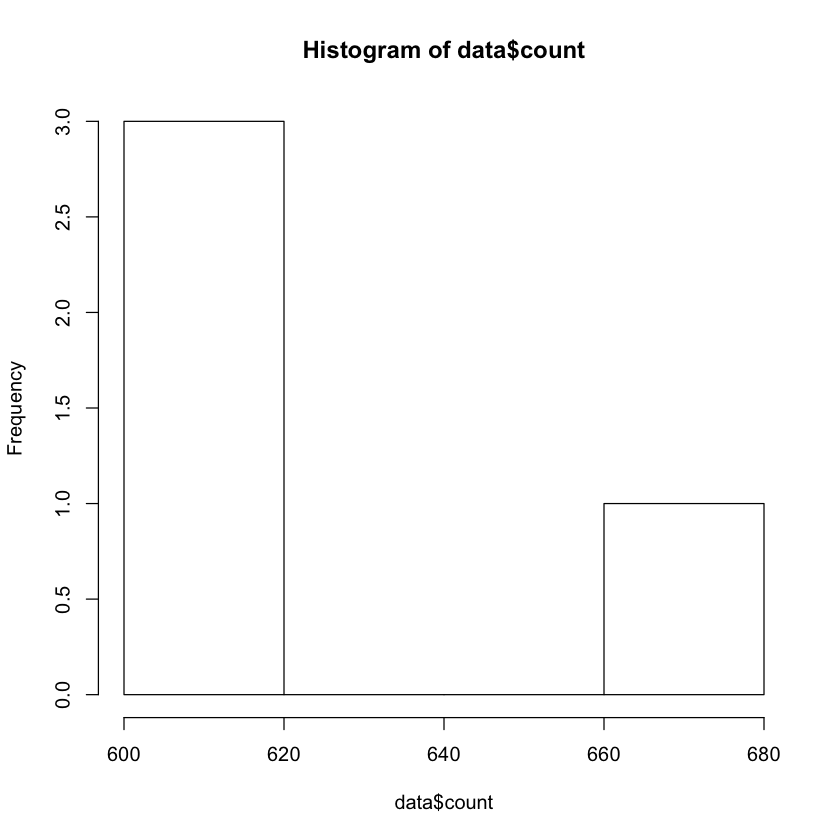

In [43]:
library(ggplot2)
hist(data$count)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


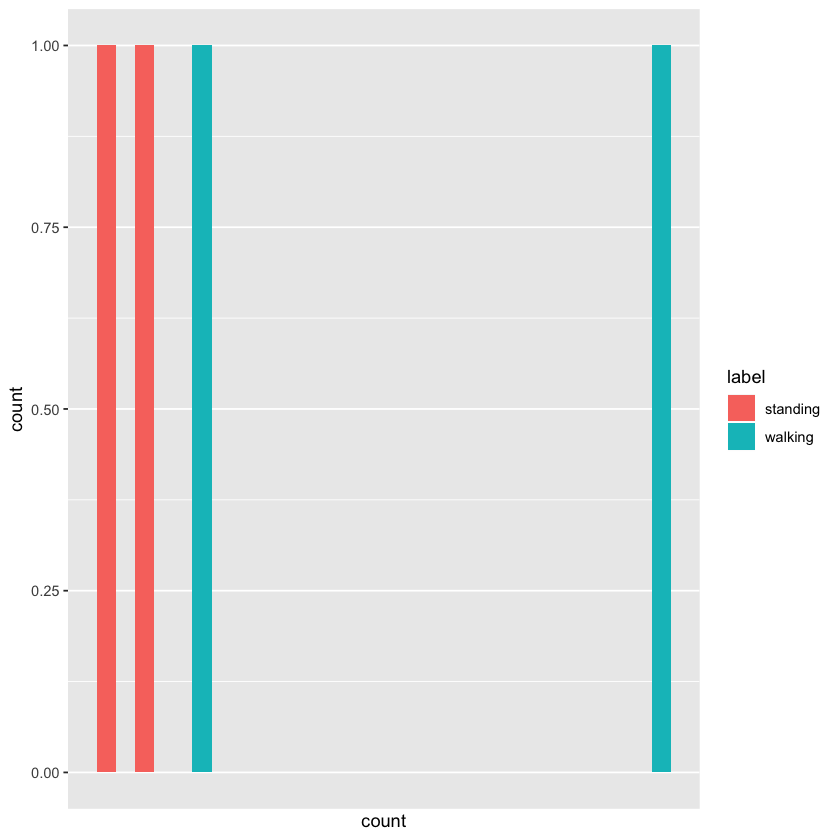

In [44]:
ggplot(data, aes(x = count,fill= label)) + geom_histogram() + scale_x_log10()

In [41]:
#result=result[data$count>5]

In [45]:
data=foreach(i=seq(1,length(result)),.combine=rbind) %do%
          {
            ts=result[[i]]
            r={}
            r$label=ts$tags$label
            r$subject=ts$tags$subject
            foreach(w=split.xts(ts$values,f="seconds",k=1),.combine = rbind) %do%
            {
              r$x=mean(w$x)
              r$y=mean(w$y)
              r$z=mean(w$z)
              d3=sqrt((w$x-r$x)^2+(w$y-r$y)^2+(w$z-r$z)^2)
              r$mean=mean(d3)
              r$sd=sd(d3)
              r$max=max(d3)
              as.data.frame(r)
            }
          }

data=na.omit(data)
data$label=as.factor(data$label)
data=data[data$label!="testing",]
data=data[data["label"]!="testing",]
data$label=factor(data$label)

In [46]:
library(caret)

In [47]:
# Plot feature space

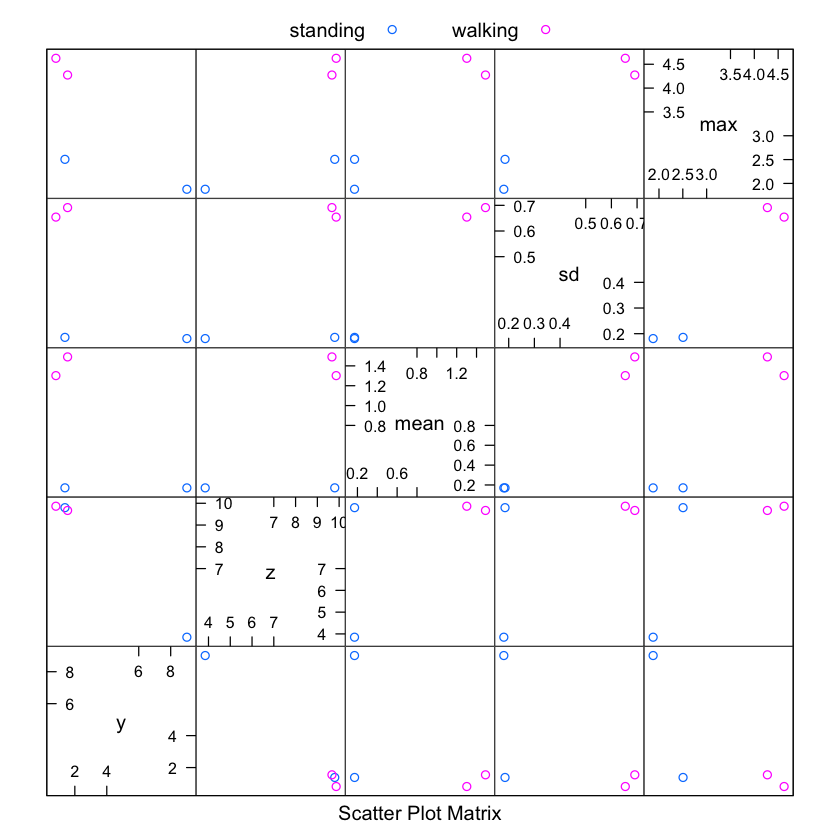

In [48]:
featurePlot(x = data[,-c(1,2)], y = data$label,  plot = "pairs", auto.key = list(columns = 2))

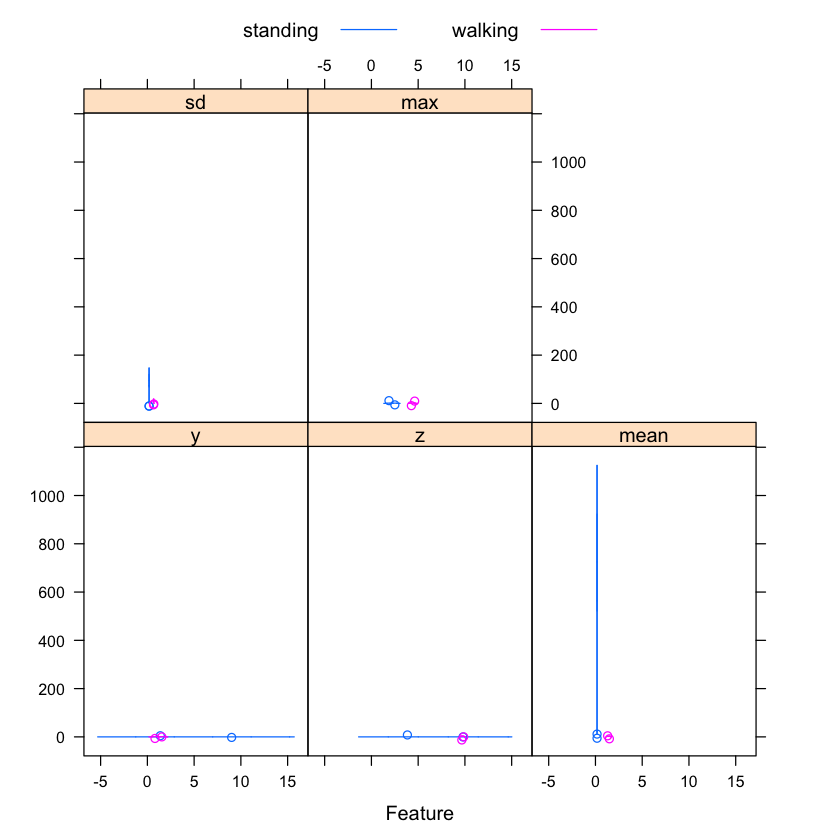

In [49]:
featurePlot(x = data[,-c(1,2)], y = data$label,  plot = "density", auto.key = list(columns = 2))

In [50]:
# Perform PCA on data

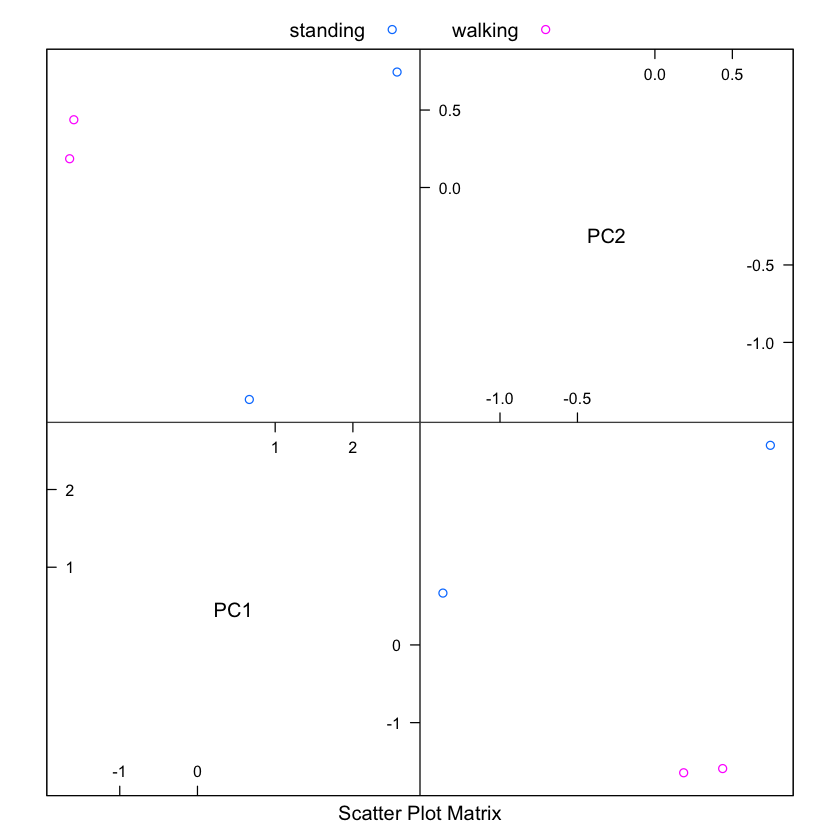

In [51]:
# Daten PCA
prep <- preProcess(data[,-c(1,2)],method=c("pca"))
data_prep=cbind(data[,c(1,2)],predict(prep,data[,-c(1,2)]))

featurePlot(x = data_prep[,-c(1,2)], y = data_prep$label,  plot = "pairs", auto.key = list(columns = 2))

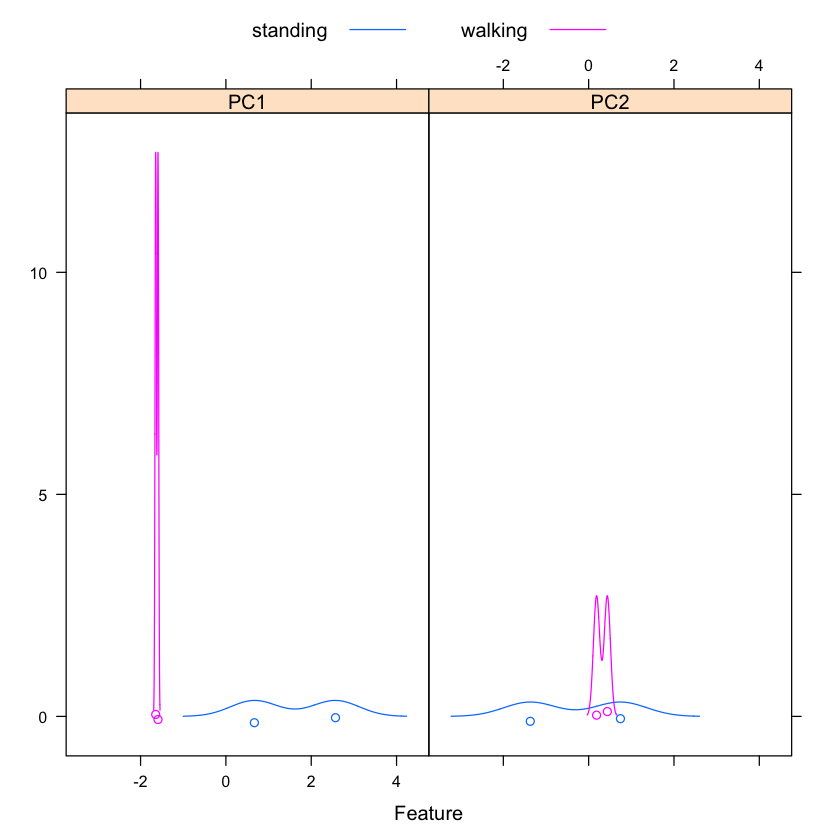

In [52]:
featurePlot(x = data_prep[,-c(1,2)], y = data_prep$label,  plot = "density", auto.key = list(columns = 2))

In [53]:
traindata=data_prep
testdata=data_prep

model=train(traindata[,-c(1,2)], traindata[,"label"], method = "nb") #try out more methods.

Warning message:
“model fit failed for Resample01: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning message:
“model fit failed for Resample01: usekernel=FALSE, fL=0, adjust=1 Error in if (any(temp)) stop("Zero variances for at least one class in variables: ",  : 
  Fehlender Wert, wo TRUE/FALSE nötig ist
”Warning message:
“predictions failed for Resample02: usekernel= TRUE, fL=0, adjust=1 Error in newdata[i, ] : Indizierung außerhalb der Grenzen
”Warning message:
“predictions failed for Resample02: usekernel=FALSE, fL=0, adjust=1 Error in newdata[i, ] : Indizierung außerhalb der Grenzen
”Warning message:
“model fit failed for Resample03: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: PC1, PC2
”Warning message:
“model fit failed for Resample04: usekernel=FALSE, fL=0, adjust=1 Error in 

“There were missing values in resampled performance measures.”Warning message in train.default(traindata[, -c(1, 2)], traindata[, "label"], method = "nb"):
“missing values found in aggregated results”

In [54]:
prediction=predict(model,testdata[,-c(1,2)])
confusionMatrix(prediction,as.factor(testdata$label))

Confusion Matrix and Statistics

          Reference
Prediction standing walking
  standing        2       0
  walking         0       2
                                     
               Accuracy : 1          
                 95% CI : (0.3976, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : 0.0625     
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : standing   
                                     

In [55]:
set.seed(1)
holdout <- createDataPartition(data_prep$label, p = .2, list = FALSE, times = 1) # Split at 80%
traindata<-data_prep[-holdout,]
testdata<-data_prep[holdout,]

model=train(traindata[,-c(1,2)], traindata[,"label"], method = "nb") #try out more methods.

Warning message:
“model fit failed for Resample01: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning message:
“model fit failed for Resample01: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: PC1, PC2
”Warning message:
“model fit failed for Resample02: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning message:
“model fit failed for Resample02: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: PC1, PC2
”Warning message:
“model fit failed for Resample03: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning 

”Warning message:
“model fit failed for Resample21: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: PC1, PC2
”Warning message:
“model fit failed for Resample22: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning message:
“model fit failed for Resample22: usekernel=FALSE, fL=0, adjust=1 Error in if (any(temp)) stop("Zero variances for at least one class in variables: ",  : 
  Fehlender Wert, wo TRUE/FALSE nötig ist
”Warning message:
“model fit failed for Resample23: usekernel= TRUE, fL=0, adjust=1 Error in density.default(xx, ...) : 
  need at least 2 points to select a bandwidth automatically
”Warning message:
“model fit failed for Resample23: usekernel=FALSE, fL=0, adjust=1 Error in if (any(temp)) stop("Zero variances for at least one class in variables: ",  : 
  Fehlender Wert, wo TRUE

Something is wrong; all the Accuracy metric values are missing:
    Accuracy       Kappa    
 Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA  
 NA's   :2     NA's   :2    


ERROR: Error: Stopping


In [56]:
prediction=predict(model,testdata[,-c(1,2)])
confusionMatrix(prediction,as.factor(testdata$label))

Confusion Matrix and Statistics

          Reference
Prediction standing walking
  standing        1       0
  walking         0       1
                                     
               Accuracy : 1          
                 95% CI : (0.1581, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : 0.25       
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : standing   
                                     

leave-one-subject-out

In [57]:
subjects<-levels(factor(data_prep$subject))

#subjects[1]

data_subject <- vector(mode = "list", length = nlevels(data$subject))

for (s in seq(1,nlevels(data$subject)))  data_subject[[s]]<- which(data$subject!=subjects[s])

trc = trainControl(index=data_subject)
model = train(data[,-c(1,2)], data$label, method = "nb", trControl=trc)

ERROR: Error in data_subject[[s]] <- which(data$subject != subjects[s]): attempt to select less than one element in integerOneIndex


In [58]:
confusionMatrix(model)

Bootstrapped (25 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction standing walking
  standing     25.0     0.0
  walking      16.7    58.3
                            
 Accuracy (average) : 0.8333
